# DataJoint Elements for [Facemap](https://github.com/MouseLand/facemap) Pose Estimation

#### Open-source data pipeline for orofacial movement tracking and pose estimation of distinct facial keypoints.

Welcome to the tutorial for the DataJoint Element for pose estimation of distinct
keypoints on the mouse face. This
tutorial aims to provide a comprehensive understanding of the open-source data pipeline
created using `element-facemap`'s pose estimation inference module.

This package is designed to seamlessly process, ingest, and track facemap's pose
estimation data, along with its associated video recording and model metadata. By the end of this
tutorial you will have a clear grasp on setting up and integrating `element-facemap`
into your specific research projects and lab. 

![flowchart](../images/diagram_flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding.

A basic understanding of the following DataJoint concepts will be beneficial to your
understanding of this tutorial: 
1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject and session metadata.
+ *Populate* video recording and models metadata.
+ Run the pose estimation task.
+ Visualize the results.

### **Setup**

This tutorial examines video data of .mp4 file format. The goal is to store, track and
manage sessions of facial pose data, including determining coordinates of facial body
parts and trajectory visualizations.

The results of this Element can be combined with **other modalities** to create a complete,
customizable data pipeline for your specific lab or study. For instance, you can combine
`element-facemap` with `element-calcium-imaging` and `element-array-ephys` to relate orofacial
behavior to neural activity.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
Let's connect to the database server.

In [2]:
dj.conn()

[2024-01-12 16:09:09,971][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-12 16:09:09,979][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `facemap_inference.py` module from `element-facemap`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

In [3]:
from tutorial_pipeline import lab, subject, session, fbe, facemap_inference, Device

[2024-01-12 16:09:17,477][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the `fbe` (SVD-based facemap) and `facemap_inference` (pose-estimation
on keypoints) schemas and their upstream dependencies, `session` and `subject` schemas
as a diagram.

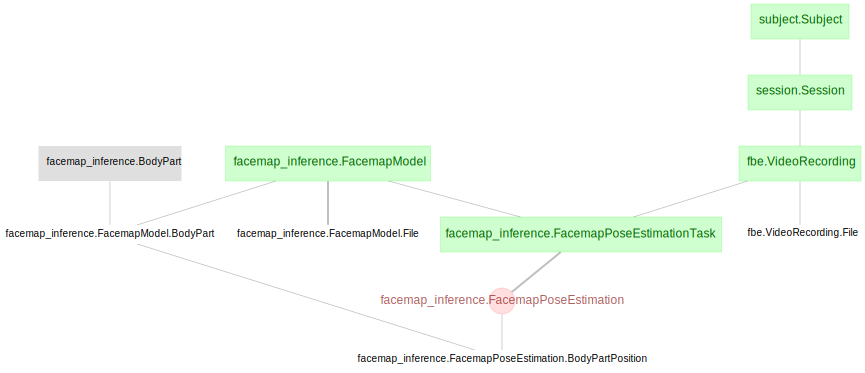

In [4]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(fbe.VideoRecording)
    + dj.Diagram(fbe.VideoRecording.File)
    + dj.Diagram(facemap_inference)
)

As evident from the diagram, this data pipeline encompasses tables associated with
model and video file data, task generation and results of model inference. A few tables, such as `subject.Subject` or `session.Session`,
while important for a complete pipeline, fall outside the scope of the `element-facemap`
tutorial, and will therefore, not be explored extensively here. The primary focus of
this tutorial will be on the `facemap_inference` schema.

### **Insert subject, session, and probe metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` methods.

In [5]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [8]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="U",
        subject_birth_date="2020-01-01",
        subject_description="Subject for Facemap Pose estimation processing.",
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,U,2020-01-01,Subject for Facemap Pose estimation processing.


Let's repeat the steps above for the `Session` table and see how the output varies
between `.describe` and `.heading`.

In [9]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [11]:
session_key = dict(subject="subject1", session_datetime="2021-04-30 12:22:15")

In [12]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject1,2021-04-30 12:22:15


Every experimental session produces a set of data files. The purpose of the `SessionDirectory` table is to locate these files. It references a directory path relative to a root directory, defined in `dj.config["custom"]`. More information about `dj.config` is provided in the [documentation](https://datajoint.com/docs/elements/user-guide/).

In [13]:
session.SessionDirectory.insert1(dict(**session_key, session_dir="subject1/session1"))
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2021-04-30 12:22:15,subject1/session1


As the Diagram indicates, both `fbe.VideoRecording` and `facemap_inference.FacemapModel` tables require entries before other downstream tables can receive data. 

Since our analysis relies on video data, let's start by viewing the `fbe.VideoRecording` table and it's part table `fbe.VideoRecording.File` and inserting into each.

In [18]:
print(fbe.VideoRecording.describe())

-> session.Session
recording_id         : int                          
---
-> Device



In [19]:
fbe.VideoRecording.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
---
device               : varchar(32)                  # 

As shown by `.describe()`, `fbe.VideoRecording` has the primary key from `Device` as a non-primary. Let's insert into `Device` before continuing.

In [20]:
print(Device.describe())

device               : varchar(32)                  
---
modality             : varchar(64)                  
description=""       : varchar(256)                 



In [21]:
Device.insert1(
    dict(
        device="camera1",
        modality="facemap",
    )
)

Now we can insert into `VideoRecording`.

In [30]:
fbe.VideoRecording.insert1(
    dict(
        **session_key,
        recording_id=0,
        device="camera1"
    )
)

fbe.VideoRecording.File.insert1(
    dict(
        **session_key,
        recording_id=0,
        file_id=0,
        file_path="inbox/subject0/session0/cam1_G7c1_1.avi"
    )
)

Next, we will insert a local pytorch model file into the `facemap_inference.FacemapModel` table. This table requires the following:
- Specify a unique `model_id`, a `model_description`, and the `full_local_model_filepath`

Note: *when running locally, the default facemap model is located in the hidden `.facemap` folder installed to your computer's home directory: `i.e. ~/.facemap/models/facemap_model_state.pt`*

In [14]:
facemap_inference.FacemapModel.insert_new_model(
    model_name="facemap_model_state.pt",
    model_id=0,
    model_description="Default facemap model",
    full_model_path="workspace/element-facemap/example_data/inbox/facemap_models/default_facemap_model.pt",
)

Let's display the `facemap_inference.FacemapModel` table to verify insertion

In [15]:
facemap_inference.FacemapModel()

model_id user assigned ID associated with a unique model,model_name name of model,model_description optional model description
0,facemap_model_state.pt,Default facemap model


### **Run the Pose Estimation Task**

We're almost ready to perform pose estimation using facemap. An important step before running the pose estimation is picking which model will be used in the analysis and the video recordings on which pose estimation is performed. The `facemap_inference.FacemapPoseEstimationTask` table manages this step.

In [31]:
print(facemap_inference.FacemapPoseEstimationTask.describe())

# Staging table for pairing of recording and Facemap parameters before processing.
-> fbe.VideoRecording
-> facemap_inference.FacemapModel
---
pose_estimation_output_dir : varchar(255)                 # output dir - stores results of Facemap Pose estimation analysis
task_description     : varchar(128)                 # Optional. Addtional task description
task_mode="trigger"  : enum('load','trigger')       
bbox=null            : longblob                     # list containing bounding box for cropping the video [x1, x2, y1, y2]



In [32]:
facemap_inference.FacemapPoseEstimationTask.heading

# Staging table for pairing of recording and Facemap parameters before processing.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
model_id             : int                          # user assigned ID associated with a unique model
---
pose_estimation_output_dir : varchar(255)                 # output dir - stores results of Facemap Pose estimation analysis
task_description     : varchar(128)                 # Optional. Addtional task description
task_mode="trigger"  : enum('load','trigger')       # 
bbox=null            : longblob                     # list containing bounding box for cropping the video [x1, x2, y1, y2]

In [39]:
facemap_inference.FacemapPoseEstimationTask.insert1(
    dict(
    **session_key,
    model_id=0,
    recording_id=0,
    pose_estimation_output_dir="outbox/subject0/session0/facemap_recordingid0_model1",
    task_mode="load",
    task_description="Facemap Inference Task, loads processed results",
    )
)

We can display the key in the `FacemapPoseEstimationTask` table to confirm it was inserted.

In [40]:
facemap_inference.FacemapPoseEstimationTask()

subject,session_datetime,recording_id,model_id user assigned ID associated with a unique model,pose_estimation_output_dir output dir - stores results of Facemap Pose estimation analysis,task_description Optional. Addtional task description,task_mode,"bbox list containing bounding box for cropping the video [x1, x2, y1, y2]"
subject1,2021-04-30 12:22:15,0,0,outbox/subject0/session0/facemap_recordingid0_model1,"Facemap Inference Task, loads processed results",load,=BLOB=


Next we will ingest the results into `FacemapPoseEstimation` and its part table `FacemapPoseEstimation.BodyPartPosition` for the key that we just inserted into the `FacemapPoseEstimationTask`

In [41]:
facemap_inference.FacemapPoseEstimation.populate(display_progress=True)

FacemapPoseEstimation:   0%|          | 0/1 [00:00<?, ?it/s]


PermissionError: [Errno 1] Operation not permitted: '/workspaces/element-facemap/example_data/outbox/subject0/session0/facemap_recordingid0_model1/cam1_G7c1_1.avi'

Once the cell above has completed run the next cells to display the `FacemapPoseEstimation` tables

In [ ]:
facemap_inference.FacemapPoseEstimation()

In [ ]:
facemap_inference.FacemapPoseEstimation.BodyPartPosition()

### **Visualize the results**
In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

In [ ]:
pe_query = {**session_key, "recording_id": 0, "model_id": 0}
pose_estimation_key = (facemap_inference.FacemapPoseEstimation & pe_query).fetch1("KEY")

Get Trajectory of X and Y coordinates

In [ ]:
# Specify all body parts, or set body_parts to a custom list
body_parts = "all"
model_name = (facemap_inference.FacemapModel & f'model_id={key["model_id"]}').fetch1(
    "model_name"
)

if body_parts == "all":
    body_parts = (facemap_inference.FacemapPoseEstimation.BodyPartPosition & key).fetch(
        "body_part"
    )
elif not isinstance(body_parts, list):
    body_parts = list(body_parts)

In [ ]:
# Construct Pandas MultiIndex DataFrame
df = None
for body_part in body_parts:
    result_dict = (
        facemap_inference.FacemapPoseEstimation.BodyPartPosition
        & {"body_part": body_part}
        & {"recording_id": key["recording_id"]}
        & {"session_id": key["session_id"]}
    ).fetch("x_pos", "y_pos", "likelihood", as_dict=True)[0]
    x_pos = result_dict["x_pos"].tolist()
    y_pos = result_dict["y_pos"].tolist()
    likelihood = result_dict["likelihood"].tolist()
    a = np.vstack((x_pos, y_pos, likelihood))
    a = a.T
    pdindex = pd.MultiIndex.from_product(
        [[model_name], [body_part], ["x", "y", "likelihood"]],
        names=["model", "bodyparts", "coords"],
    )
    frame = pd.DataFrame(a, columns=pdindex, index=range(0, a.shape[0]))
    df = pd.concat([df, frame], axis=1)
df

In [ ]:
df_xy = df.iloc[:, df.columns.get_level_values(2).isin(["x", "y"])][
    "facemap_model_state.pt"
]
df_xy.mean()

Plot coordinates across time for each body part

In [ ]:
df_xy.plot().legend(loc="best", prop={"size": 5})

In [ ]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map("_".join)

Plot Trace Overlays of each body part across time

In [ ]:
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(20)
fig.set_figheight(15)

df_flat.plot(x="eye(front)_x", y="eye(front)_y", ax=ax[0, 0])
df_flat.plot(x="eye(back)_x", y="eye(back)_y", ax=ax[0, 0])
df_flat.plot(x="eye(bottom)_x", y="eye(bottom)_y", ax=ax[0, 0])

df_flat.plot(x="nose(tip)_x", y="nose(tip)_y", ax=ax[1, 0])
df_flat.plot(x="nose(bottom)_x", y="nose(bottom)_y", ax=ax[1, 0])
df_flat.plot(x="nose(r)_x", y="nose(r)_y", ax=ax[1, 0])
df_flat.plot(x="nosebridge_x", y="nosebridge_y", ax=ax[1, 0])

df_flat.plot(x="mouth_x", y="mouth_y", ax=ax[0, 1])
df_flat.plot(x="lowerlip_x", y="lowerlip_y", ax=ax[0, 1])
df_flat.plot(x="paw_x", y="paw_y", ax=ax[0, 1])

df_flat.plot(x="whisker(I)_x", y="whisker(I)_y", ax=ax[1, 1])
df_flat.plot(x="whisker(II)_x", y="whisker(II)_y", ax=ax[1, 1])
df_flat.plot(x="whisker(II)_x", y="whisker(II)_y", ax=ax[1, 1])

### **Visualize Keypoints Data**

In [ ]:
from matplotlib import cm

colors = cm.get_cmap("jet")(np.linspace(0, 1.0, len(body_parts)))

Display the x and y coordinates stored in the `BodyPartPosition` table, for the `pose_estimation_key` of interest

In [ ]:
(facemap_inference.FacemapPoseEstimation.BodyPartPosition & pose_estimation_key)

Fetch the keypoints_data from the database as a dictionary in order to index and reshape it.

In [ ]:
keypoints_data = (
    facemap_inference.FacemapPoseEstimation.BodyPartPosition & pose_estimation_key
).fetch(as_dict=True)

In [ ]:
pose_x_coord = []
pose_y_coord = []
pose_likelihood = []
for body_part_data in keypoints_data:
    pose_x_coord.append(body_part_data["x_pos"][:])
    pose_y_coord.append(body_part_data["y_pos"][:])
    pose_likelihood.append(body_part_data["likelihood"][:])

pose_x_coord = np.array([pose_x_coord])  # size: key points x frames
pose_y_coord = np.array([pose_y_coord])  # size: key points x frames
pose_likelihood = np.array([pose_likelihood])  # size: key points x frames
pose_data = np.concatenate(
    (pose_x_coord, pose_y_coord, pose_likelihood), axis=0
)  # size: 3 x key points x frames
pose_x_coord = pose_data[0, :, :]
pose_y_coord = pose_data[1, :, :]
pose_liklihood = pose_data[2, :, :]

Plot keypoints for a subset of frames

In [ ]:
start_frame = 100
end_frame = 500

plt.figure(figsize=(15, 5), dpi=100)
for i, bodypart in enumerate(body_parts):
    plt.plot(
        np.arange(start_frame, end_frame),
        pose_x_coord[i, start_frame:end_frame],
        "-",
        c=colors[i],
        label=bodypart,
    )
    plt.plot(
        np.arange(start_frame, end_frame),
        pose_y_coord[i, start_frame:end_frame],
        "--",
        c=colors[i],
    )
plt.xlabel("Frame")
plt.ylabel("Keypoint coordinates")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

Plot a subset of bodypart keypoints for a subset of frames

In [ ]:
subset_bodyparts = ["whisker(I)", "whisker(II)", "whisker(III)"]
start_frame = 100
end_frame = 500

plt.figure(figsize=(15, 5), dpi=100)
for i, bodypart in enumerate(body_parts):
    if bodypart in subset_bodyparts:
        plt.plot(
            np.arange(start_frame, end_frame),
            pose_x_coord[i, start_frame:end_frame],
            "-",
            c=colors[i],
            label=bodypart,
        )
        plt.plot(
            np.arange(start_frame, end_frame),
            pose_y_coord[i, start_frame:end_frame],
            "--",
            c=colors[i],
        )
plt.xlabel("Frame")
plt.ylabel("Keypoint coordinates")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

#### Filter keypoints data by confidence

Use Facemap's `filter_outliers` function to remove outliers by applying a median filter to the keypoints data.

In [ ]:
from facemap.utils import filter_outliers

# Use the following function to filter outliers in the keypoints data (see docstring for details)
"""
utils.filter_outliers(x, y, filter_window=15, baseline_window=50, max_spike=25, max_diff=25)
x: x coordinates of keypoints
y: y coordinates of keypoints
filter_window: window size for median filter (default: 15)
baseline_window: window size for baseline estimation (default: 50)
max_spike: maximum spike size (default: 25)
max_diff: maximum difference between baseline and filtered signal (default: 25)
"""

plt.figure(figsize=(15, 5), dpi=100)
for i, bodypart in enumerate(body_parts):
    if bodypart in subset_bodyparts:
        x, y = filter_outliers(pose_x_coord[i], pose_y_coord[i])
        plt.plot(
            np.arange(start_frame, end_frame),
            x[start_frame:end_frame],
            "-",
            c=colors[i],
            label=bodypart,
        )
        plt.plot(
            np.arange(start_frame, end_frame),
            y[start_frame:end_frame],
            "--",
            c=colors[i],
        )
plt.xlabel("Frame")
plt.ylabel("Keypoint coordinates")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Filtered keypoints")
plt.show()